In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer

import plotly.express as px
import plotly.graph_objects as go

import os
import re 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

sns.set()

C:\Users\dinar\AppData\Local\Temp\ipykernel_15848\765240082.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def show_plot(df, pred='preds'):
    agg_data = df.copy()
    agg_data.pricing_date = pd.to_datetime(agg_data.pricing_date)
    agg_data.forecast_date = agg_data.forecast_date.astype(str)

    agg_data = agg_data.set_index('pricing_date')

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    fig = px.line(df, x=df.index, y=pred, color='forecast_date', markers=True, height=600, width=1200)
    fig.update_traces(opacity=0.5, line=dict(width=2, ))

    df = agg_data.copy()
    df = df.sort_index(ascending=True)

    x = df.index
    y = df['target']
    name = 'target'
    fig.add_trace(
        go.Scatter(x=x, y=y, name=name, mode='lines+markers', opacity=0.5, marker=dict(color='darkgray', size=10),
                   line=dict(width=18, color='gray')))  # ,shape = 'hv'
    fig.show()
    

def show_results(results, save_path):
    thresh = 0.2

    results['nth_day'] = results.groupby('forecast_date')['preds'].cumcount()
    results['preds_diff'] = results.groupby('forecast_date')['preds'].diff()
    results['traget_diff'] = results.groupby('forecast_date')['target'].diff()
    results['preds_diff_cum'] = results.groupby('forecast_date')['preds_diff'].cumsum()
    results['traget_diff_cum'] = results.groupby('forecast_date')['traget_diff'].cumsum()
    results['preds_direct'] = results['preds_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['traget_direct'] = results['traget_diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    results['preds_direct_cum'] = results['preds_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['traget_direct_cum'] = results['traget_diff_cum'].apply(
        lambda x: 1 if x > thresh else (-1 if x < -thresh else 0))
    results['pnl_stra_daily_direct'] = results['preds_direct'] * results['traget_diff']
    results['pnl_stra_cum_direct'] = results['preds_direct_cum'] * results['traget_diff_cum']

    fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    results.pivot_table(index='pricing_date', values='pnl_stra_cum_direct', aggfunc=sum).cumsum().plot(ax=ax[0],
                                                                                                       title='pnl_stra_cum_direct')
    results.pivot_table(index='pricing_date', values='pnl_stra_daily_direct', aggfunc=sum).cumsum().plot(ax=ax[1],
                                                                                                         title='pnl_stra_daily_direct')
    fig.show()

In [3]:
def iterate(data, idx, step=100, low=False):
    # change step size if we have smaller input data
    step = 50 if low else 100

    # select starting point depending on the size of the input data
    start = idx * step if idx > 0 else 0

    # select ending point (if smaller, 300 days rolling window. Otherwise, 600)
    if low:
        end = 300 + step * idx
    else:
        end = 600 + step * idx

    train, val = data.iloc[start: start + end - 30, :], data.iloc[start + end - 30: start + end, :]
    return train, val


def custom_pnl_10(y_pred, y_true):
    nth = 10

    thresh = 0.2
    try:
        diff = y_pred[nth - 1] - y_pred[0]
    except IndexError:
        diff = y_pred[-1] - y_pred[0]

    direction = 1 if diff > thresh else (-1 if diff < thresh else 0)
    pnl = diff * direction

    return 'pnl', pnl



In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

class TargetFeature:
    def __init__(self, results_path, data, test_start, test_end, target='F380 M2/M3',
                 features=None, **kwargs):
        self.results_path = results_path

        self.data = data
        self.test_start = test_start
        self.test_end = test_end
        self.target = target
        self.features = features

        # define pd.DataFrame to store resulting df
        self.target_and_feature = None

        # define scaler
        self.scaler = MinMaxScaler()

        # define a starting message for log
        self.message = 'Task 2 [TargetFeature]:\n\t'

    def __call__(self, *args, **kwargs):
        self._setup()

    def _setup(self):
        # self.log(self.log_path, f'{self.message}Internal setup for target and feature columns...')
        target = self.data[self.target]
        target.interpolate(inplace=True)
        target.dropna(inplace=True)
        
        self.target_and_feature = pd.DataFrame(index=self.data.index)
        self.target_and_feature['actual_target'] = target
        self.target_and_feature['predicted_target'] = target
        
        if self.features is not None:            
            decompose = seasonal_decompose(target, model='additive', period=4)
            
            for feature in self.features:
                if feature in ['rolling', 'all']:
                    rolling = self.data[self.target].rolling(5).mean()
                    self.target_and_feature['actual_rolling'] = rolling[:self.test_end]
                    self.target_and_feature['predicted_rolling'] = rolling[:self.test_start]
                if feature in ['seasonality', 'all']:
                    self.target_and_feature['actual_seasonality'] = decompose.seasonal
                if feature in ['fft', 'all']:
                    fft_value = np.fft.fft(target)
                    self.target_and_feature['actual_fft_real'] = fft_value.real
                    self.target_and_feature['predicted_fft_real'] = self.target_and_feature['actual_fft_real'][:self.test_start]
                    self.target_and_feature['actual_fft_imag'] = fft_value.imag
                    self.target_and_feature['predicted_fft_imag'] = self.target_and_feature['actual_fft_imag'][:self.test_start]
                if feature in ['diff', 'all']:
                    self.target_and_feature['actual_diff'] = target.diff()
                    self.target_and_feature['predicted_diff'] = self.target_and_feature['actual_diff'][:self.test_start]
                if feature in ['seasonal_diff', 'all']:
                    self.target_and_feature['actual_seasonal_diff'] = decompose.seasonal.diff()
                if feature in ['ewm', 'all']:
                    self.target_and_feature['actual_ewm'] = target.ewm(span=30, adjust=True).mean()
                    self.target_and_feature['predicted_ewm'] = self.target_and_feature['actual_ewm'][:self.test_start]
            
            # self.target_and_feature.dropna(inplace=True)

            # fit a scaler
            columns = [x for x in self.target_and_feature if 'predicted' not in x and 'target' not in x]
            self.scaler.fit(self.target_and_feature[columns])


    def get_target_feature(self, end_date, start_date=None, include_past=False):
        # return all values until specified date
        if include_past:
            if start_date is not None:
                # self.log(self.log_path, f'Returning dates from {start_date} to {end_date}.')
                return self.target_and_feature.loc[start_date:end_date, :]
            # self.log(self.log_path, f'Returning all dates until {end_date}')
            return self.target_and_feature.loc[:end_date, :]

        # return one-day results
        try:
            entry = pd.DataFrame(self.target_and_feature.loc[end_date, :]).T
        except KeyError:
            # self.log(self.log_path, f'{self.message}Date {end_date} does not exist!', CRITICAL)
            raise KeyError(f'{self.message}Date {end_date} does not exist!')
        else:
            # self.log(self.log_path, f'Returned one-day instance for {end_date}.')
            return entry

    def set_target_feature(self, date, column, value):
        fmt = '%Y-%m-%d'

        # raise error if the supplemented date is less than the test start
        # if datetime.strptime(self.test_start, fmt) < datetime.strptime(date, fmt):
        #     message = f'Illegal date substitution {date}, expected to see dates between {self.test_start} to {date}.'
        #     self.log(self.log_path, self.message + message, CRITICAL)
        #     raise Exception(message)
        
        # with open('track.txt', 'a') as fout:
        #     fout.writelines(f'{date} - {column}: {value}\n')

        # get previous value
        previous = self.target_and_feature.loc[date, column]

        # log information
        # self.log(self.log_path, f'{self.message}Setting new value for {column}. Old: {previous}, new: {value}')

        # set new value
        self.target_and_feature.loc[date, column] = value

        # save current state
        # self.target_and_feature.reset_index(inplace=True)
        self.target_and_feature.to_csv(f'{self.results_path}/complete_target_feature_df.csv', index=True)
        # self.log(self.log_path, f'{self.message}Saving intermediate results in {self.results_path} CSV file.')


In [210]:
def train_model(data, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, final_refit=True, path=None, 
                use_features=False, n_estimators=1500, target_features=None, feat_importance='total_gain'):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    
    data.interpolate('linear', inplace=True)
    data.dropna(inplace=True)
    
    # create a target feature class
    if target_features is None:
        target_feature = TargetFeature(path, data, test_start, test_end, features=None)
    else:
        target_features = [target_features] if isinstance(target_features, str) else target_features
        target_feature = TargetFeature(path, data, test_start, test_end, features=target_features)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    if target_col in columns:
        columns = list(columns)
        columns.remove(target_col)
        
    if len(columns) > 1:
        data = data[columns]
    
    # split to train/test
    train = data[data.index < test_start]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    if use_features:
    
        all_target_cols = ['actual_rolling', 'actual_seasonality', 'actual_fft_real', 'actual_fft_imag', 'actual_diff', 'actual_seasonal_diff', 'actual_ewm']
        all_pred_target_cols = ['predicted_rolling', 'predicted_fft_real', 'predicted_fft_imag', 'predicted_diff', 'predicted_ewm']

        current_target_cols = [col for col in all_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_target_cols
        current_pred_target_cols = [col for col in all_pred_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_pred_target_cols
        
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns) + len(current_target_cols)}_use_fe={use_features}_feat-import={feat_importance}_targ_fe={"_".join(target_features)}.model'
    else:
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns)}_use_fe={use_features}_feat-import={feat_importance}_targ_fe=False.model'
    
    # start pretraining the model
    for idx in range(300):
        # get batches
        train_temp, valid_temp = iterate(train, idx, low=False)

        # break if there are fewer values
        if len(train_temp) < 200 or len(valid_temp) <= 5: break

        # get rolling and target columns
        if use_features:
            train_temp[[target_col] + current_target_cols] = \
                target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[[target] + current_target_cols].values
            valid_temp[[target_col] + current_target_cols] = \
                target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[[target] + current_target_cols].values

            train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_temp.dropna(inplace=True)
            valid_temp.dropna(inplace=True)
            
            y_train = train_temp[target_col]
            y_test = valid_temp[target_col]
            
            train_temp.drop(columns=target_col, inplace=True)
            valid_temp.drop(columns=target_col, inplace=True)

            # normalize rolling
            train_temp[current_target_cols] = target_feature.scaler.transform(train_temp[current_target_cols])
            valid_temp[current_target_cols] = target_feature.scaler.transform(valid_temp[current_target_cols])

        else:
            y_train = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[target].values
            y_test = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[target].values

        if idx == 0:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist')
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)
            
        else:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
            model.load_model(model_name)
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)

        model.save_model(model_name)

    # final refit
    full_train = train.copy()
    
    if use_features:
        full_train[[target_col] + current_target_cols] = target_feature.get_target_feature(end_date=train.index.max(),
                                                                                           include_past=True)[[target] + current_target_cols].values

    else:
        full_train[target_col] = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[target].values
        
    full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_train.dropna(inplace=True)
    
    y_train = full_train[target_col]
    full_train.drop(columns=target_col, inplace=True)

    if use_features:
        # normalize data
        full_train[current_target_cols] = target_feature.scaler.transform(full_train[current_target_cols])
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
    model.load_model(model_name)
    model.fit(full_train, y_train, verbose=False)

    model.save_model(model_name)

    if use_features:
        return model, train, test, scaler, target_feature, current_target_cols, model_name
    
    return model, train, test, scaler, target_feature, model_name


def get_columns(columns_selection, model, feat_eng_thresh=30, feat_importance='total_gain'):
    if columns_selection == 'xgboost':
        scores = model.get_booster().get_score(importance_type=feat_importance)
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] >= feat_eng_thresh]['columns'].to_list()


def get_predictions(data, results_folder, test_start, test_end, columns_selection='xgboost', use_features=False, 
                    n_estimators=1500, target_features=None, use_fe=False, feat_eng_thresh=30, feat_importance='total_gain'):
    if use_fe:
        model, train, test, scaler, target_feature, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                 columns=data.columns, path=results_folder, 
                                                                 use_features=False, n_estimators=n_estimators, target_features=None,
                                                                 feat_importance='total_gain')

        columns = get_columns(columns_selection, model, feat_eng_thresh, feat_importance=feat_importance)
        columns = [x for x in columns if not x.startswith('rolling')]
        
        print('Removing temporary model:', model_name)
        os.remove(model_name)
    else:
        columns = data.drop(columns='F380 M2/M3').columns
    
    # refit the model with selected columns
    if use_features:
        model, train, test, scaler, target_feature, current_target_cols, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                                                model_suffix='partial', columns=columns, path=results_folder, 
                                                                                                use_features=use_features, n_estimators=n_estimators, 
                                                                                                target_features=target_features, feat_importance=feat_importance)
    else:
        model, train, test, scaler, target_feature, model_name = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                            model_suffix='partial', columns=columns, path=results_folder, 
                                                                            use_features=use_features, n_estimators=n_estimators, 
                                                                            target_features=target_features, feat_importance=feat_importance)
    
    print('============')
    print(f'Use target features: {use_features} [{target_features}]')
    print(f'Use feature engineering for column selection: {use_fe} [type={feat_importance} >= {feat_eng_thresh}]')
    print('Model is stored in:', model_name)
    print('Number of columns:', len(columns))
    print('Columns:', columns, end='\n============\n')
    
    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()

    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy()

            # keep track of every 0th value to select all actual targets and then predictions afterward
            first_day, second_day = None, None

            for counter2 in range(window_size):
                try:
                    sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                    if counter2 == 1:
                        second_day = sliding_start_date

                except IndexError:
                    pass
                else:                    
                    expanding_history = full_history[full_history.index <= sliding_start_date]

                    # get test value and convert to DMatrix
                    testx = pd.DataFrame(expanding_history.iloc[-1, :]).T
                    testx = testx[columns]

                    # normalize features
                    testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)

                    # select current state of the target/feature dataframe
                    current_values = target_feature.get_target_feature(sliding_start_date, include_past=True)
                    
                    # select actual values for the first predictions
                    if counter2 == 0:
                        current_targets = current_values['actual_target']
                    else:
                        current_targets = current_values['actual_target'].copy()
                        current_targets.loc[second_day:sliding_start_date] = current_values['predicted_target'].loc[
                                                                             second_day:sliding_start_date]
                    if use_features:
                        decompose = seasonal_decompose(current_targets, model='additive', period=4)
                        fft_value = np.fft.fft(current_targets)
                        
                        features = pd.DataFrame(index=current_targets.index)
                        
                        for feature in current_target_cols:                            
                            if feature == 'actual_rolling':
                                method = current_targets.rolling(5).mean()
                            if feature == 'actual_ewm':
                                method = current_targets.ewm(span=30, adjust=True).mean()
                            if feature == 'actual_trend':
                                method = decompose.trend
                            if feature == 'actual_seasonality':
                                method = current_values['actual_seasonality']
                            if feature == 'actual_fft_imag':
                                method = fft_value.imag 
                            if feature == 'actual_fft_real':
                                method = fft_value.real
                            if feature == 'actual_diff':
                                method = current_targets.diff()
                            if feature == 'actual_seasonal_diff':
                                method = decompose.seasonal.diff()
                            
                            features[feature] = method
                        
                        try:
                            features = pd.DataFrame(target_feature.scaler.transform(features), index=features.index, columns=features.columns)
                            features = features.loc[:sliding_start_date]
                        except ValueError:
                            pass
                        
                        for col in features.columns:
                            testx[col] = features.loc[sliding_start_date, col]

                    # get predictions
                    prediction = model.predict(testx)

                    # append new prediction to predicted target column
                    target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_target', prediction)

                    if use_features:
                        inverse = target_feature.scaler.inverse_transform(testx[current_target_cols])
                        
                        for idx, feature in enumerate(current_target_cols):
                            target_feature.set_target_feature(str(sliding_start_date)[:10], feature, inverse[0][idx])

                    # record results
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'pricing_date': testx.index,
                        'preds': prediction,
                        'target': current_values.loc[sliding_start_date, 'actual_target'],
                        'forecast_date': sliding_history.index.min()

                    })], ignore_index=True)
            
            # with open('predicted_track.csv', 'a') as fout:                
            #     out = []
                
            #     if use_features:
            #         for idx, feature in enumerate(current_target_cols):
            #             res = target_feature.get_target_feature(str(sliding_start_date)[:10], str(sliding_history.index.min())[:10], include_past=True)[feature]
                        
            #             out.append(','.join([str(x)[:10] for x in res.index.tolist()]))
            #             out.append('\n')
            #             out.append(','.join([str(x) for x in res.values]))
            #             out.append('\n')
                
            #     fout.writelines(out)
                
                    
    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    show_plot(results_df)

    return {'results_df': results_df, 'model': model, 'target_feature': target_feature, 
            'target_features': target_features, 'model_name': model_name, 'columns': columns,
            'scaler': scaler}

In [6]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard
import pickle
import shutil
import time, stat

def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
    else:
        if len(os.listdir(path)) > 0:
            return 'exists'
    return 'ok'        

def pipeline(data_path, use_abs_time_features, use_neg_features, target, results_folder, test_start, test_end, 
             use_targ_features, use_feature_eng, feat_eng_thresh, feat_importance, target_features):
    # open the dataset
    data = pd.read_csv(data_path)
    data.pricing_date = pd.to_datetime(data.pricing_date)
    data.set_index('pricing_date', inplace=True)

    # add sin time-related values
    data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
    data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
    data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
    data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)
    
    if use_abs_time_features:
        data['year_num'] = data.index.year
        data['month_num'] = data.index.month
        data['day_num'] = data.index.day
        data['dow_num'] = data.index.dayofweek
        
    if use_neg_features:
        for col in list(data.drop(columns=target).columns):
            data[f'neg_{col}'] = -data[col]
    
    data.interpolate('linear', inplace=True)
    data.dropna(inplace=True)
    
    results = get_predictions(data.copy(), results_folder, test_start, test_end, use_features=use_targ_features, n_estimators=100, 
                            target_features=target_features, use_fe=use_feature_eng, feat_eng_thresh=feat_eng_thresh, feat_importance=feat_importance)
    
    x_scaler = results['scaler']
    y_scaler = results['target_feature'].scaler
    targ_features = pd.read_csv(os.path.join(results_folder, 'complete_target_feature_df.csv'))
    targ_features.pricing_date = pd.to_datetime(targ_features.pricing_date)
    targ_features.set_index('pricing_date', inplace=True)
    
    X_test, y_test = data.drop(columns=target).loc[test_start:test_end][results['columns']], data[target].loc[test_start:test_end]
    X_test = pd.DataFrame(x_scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    if isinstance(targ_features, list):
        cols = ['actual_' + x for x in results['target_features']]
        X_test[cols] = y_scaler.transform(targ_features.loc[test_start:test_end][cols])  
    
    # save test dataframes
    data = X_test.copy()
    data[target] = y_test.values
    data.reset_index().to_csv(os.path.join(results_folder, 'data.csv'))
    
    # save the results pickle
    with open(os.path.join(results_folder, 'pickled.pickle'), 'wb') as fout:
        pickle.dump(results, fout, protocol=pickle.HIGHEST_PROTOCOL)


def run_model(data_path, test_start, test_end, target, use_abs_time_features=True, use_targ_features=True,
              use_feature_eng=True, feat_eng_thresh=30, use_neg_features=False, target_features=['rolling', 'ewm'], feat_importance='total_gain'):
    
    path = 'experiments'
    if not os.path.exists: os.mkdir('experiments'); os.mkdir(os.path.join(path, 'models'))
    
    tf = f'{"-".join(target_features)}' if (use_targ_features and isinstance(target_features, list)) else False
    
    results_folder = os.path.join(path, f'predict-{test_start}-{test_end}_target={target.replace("/", "")}_abs-timef={use_abs_time_features}_fe={use_feature_eng}={feat_importance}_neg-fe={use_neg_features}_tf={tf}')
    
    if create_folder(results_folder) != 'exists':
        pipeline(data_path, use_abs_time_features, use_neg_features, target, results_folder, test_start, test_end, 
                           use_targ_features, use_feature_eng, feat_eng_thresh, feat_importance, target_features)
    elif not os.path.exists(os.path.join(results_folder, 'data.csv')) or not os.path.exists(os.path.join(results_folder, 'pickled.pickle')):
        print('Some files are missing... Rerunning the pipeline...')
        os.system('rmdir /S /Q "{}"'.format(results_folder))
        
        run_model(data_path, test_start, test_end, target, use_abs_time_features, use_targ_features, use_feature_eng, 
                  feat_eng_thresh, use_neg_features, target_features, feat_importance)

    print('Loading results from:', results_folder)
    
    data = pd.read_csv(os.path.join(results_folder, 'data.csv'))
    data.pricing_date = pd.to_datetime(data.pricing_date)
    data.set_index('pricing_date', inplace=True)
    
    X_test, y_test = data.drop(columns=target), data[target]
    
    targ_features = pd.read_csv(os.path.join(results_folder, 'complete_target_feature_df.csv'))
    targ_features.pricing_date = pd.to_datetime(targ_features.pricing_date)
    targ_features.set_index('pricing_date', inplace=True)
    
    results = pickle.load(open(os.path.join(results_folder, 'pickled.pickle'), 'rb'))
    
    if 'Unnamed: 0' in X_test.columns:
        X_test.drop(columns='Unnamed: 0', inplace=True)
        
    if isinstance(target_features, list):
        y_scaler = results['target_feature'].scaler
        cols = ['actual_' + x for x in results['target_features']]
        X_test[cols] = y_scaler.transform(targ_features.loc[test_start:test_end][cols])
    
    explainer = RegressionExplainer(results['model'], X_test, y_test)
    ExplainerDashboard(explainer, depth=10).run()


In [189]:
data = pd.read_csv('../data/data_2024-02-02.csv')
data

,pricing_date,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,...,_rgp_03_sz_3,_rgp_04_sz_3,_rgp_05_sz_3,_rgp_06_sz_3,_rgp_07_sz_3,_rgp_08_sz_3,_rgp_09_sz_3,_rgp_10_sz_3,_rgp_11_sz_3,F380 M2/M3
0,2017-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.50
1,2017-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.30
2,2017-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,530.0,0.000000,920.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.70
3,2017-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1060.0,0.000000,615.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.85
4,2017-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1060.0,0.000000,3.333333,0.0,0.0,0.0,0.000000,0.0,0.0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1859,2024-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,266.666667,0.000000,0.0,0.0,0.0,65.555556,0.0,0.0,NaN
1860,2024-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,266.666667,0.000000,0.0,0.0,0.0,65.555556,0.0,0.0,NaN
1861,2024-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,266.666667,0.000000,0.0,0.0,0.0,65.555556,0.0,0.0,NaN
1862,2024-02-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,266.666667,0.000000,0.0,0.0,0.0,30.000000,0.0,0.0,NaN


In [190]:
data.pricing_date = pd.to_datetime(data.pricing_date)
data.interpolate('linear', inplace=True)

In [191]:
data.set_index('pricing_date', inplace=True)
train = data[data.index < '2023-01-01']
test  =  data[(data.index >= '2023-01-01') & (data.index <= '2024-01-01')]

In [192]:
for idx in range(1, 11, 1):
    print(-idx)
    train[f't-{idx}'] = train['F380 M2/M3'].shift(-idx)

train.iloc[:, -12:]

-1
-2
-3
-4
-5
-6
-7
-8
-9
-10


,_rgp_11_sz_3,F380 M2/M3,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
pricing_date,,,,,,,,,,,,
2017-01-10,0.0,1.500,1.30,1.70,1.85,2.00,1.65,1.45,1.20,0.85,1.20,0.800
2017-01-11,0.0,1.300,1.70,1.85,2.00,1.65,1.45,1.20,0.85,1.20,0.80,0.150
2017-01-12,0.0,1.700,1.85,2.00,1.65,1.45,1.20,0.85,1.20,0.80,0.15,0.150
2017-01-13,0.0,1.850,2.00,1.65,1.45,1.20,0.85,1.20,0.80,0.15,0.15,0.200
2017-01-16,0.0,2.000,1.65,1.45,1.20,0.85,1.20,0.80,0.15,0.15,0.20,-0.275
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.0,1.375,1.00,1.25,1.25,1.50,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,0.0,1.000,1.25,1.25,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,0.0,1.250,1.25,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
shifted_targets = pd.DataFrame(columns=[f't{x}' for x in range(-1, -11, -1)], index=data[data.index < '2024-01-01'].index)
shifted_targets = shifted_targets[::-1]
shifted_targets

,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
pricing_date,,,,,,,,,,
2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2017-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
reversed_df = data[data.index < '2024-01-01'].reset_index()[::-1]
reversed_df

,pricing_date,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,...,_rgp_03_sz_3,_rgp_04_sz_3,_rgp_05_sz_3,_rgp_06_sz_3,_rgp_07_sz_3,_rgp_08_sz_3,_rgp_09_sz_3,_rgp_10_sz_3,_rgp_11_sz_3,F380 M2/M3
1818,2023-12-29,0.0,0.0,0.0,0.0,0.0,2.847652,0.0,0.0,0.0,...,-2040.055556,-234.888889,-555.555556,0.0,0.0,0.0,1732.888889,0.0,0.0,3.550
1817,2023-12-28,0.0,0.0,0.0,0.0,0.0,2.700562,0.0,0.0,0.0,...,-1885.055556,-341.555556,-275.555556,0.0,0.0,0.0,1504.555556,0.0,0.0,3.450
1816,2023-12-27,0.0,0.0,0.0,0.0,0.0,2.791667,0.0,0.0,0.0,...,-1749.500000,408.444444,-93.333333,0.0,0.0,0.0,1224.555556,0.0,0.0,3.150
1815,2023-12-26,0.0,0.0,0.0,0.0,0.0,2.404817,0.0,0.0,0.0,...,-1313.944444,761.777778,0.000000,0.0,0.0,0.0,991.222222,0.0,0.0,2.950
1814,2023-12-25,0.0,0.0,0.0,0.0,0.0,2.300491,0.0,0.0,0.0,...,-1075.888889,1741.777778,0.000000,0.0,0.0,0.0,1017.888889,0.0,0.0,3.225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2017-01-16,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1060.000000,0.000000,3.333333,0.0,0.0,0.0,0.000000,0.0,0.0,2.000
3,2017-01-13,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1060.000000,0.000000,615.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.850
2,2017-01-12,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,530.000000,0.000000,920.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.700
1,2017-01-11,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.300


In [195]:
for i, (idx, row) in enumerate(reversed_df[['F380 M2/M3']].iterrows()):
    vals = []

    for ix in range(1, 11):
        try:
            # print((idx + ix) % idx)
            # print(idx) 
            ixs = idx - ix
            val = reversed_df.iloc[-ixs - 1]['F380 M2/M3']
            print('idx:', ixs, 'value:', val)
            vals.append(val)

        except IndexError:
            vals.append(np.nan)
        except ZeroDivisionError:
            vals.append(np.nan)
    print(len(vals), vals)
    shifted_targets.iloc[i, :] = vals
    print(shifted_targets.iloc[i, :])
    

idx: 1817 value: 3.45
idx: 1816 value: 3.15
idx: 1815 value: 2.95
idx: 1814 value: 3.225
idx: 1813 value: 3.5
idx: 1812 value: 2.85
idx: 1811 value: 2.75
idx: 1810 value: 2.75
idx: 1809 value: 2.75
idx: 1808 value: 2.0
10 [3.45, 3.15, 2.95, 3.225, 3.5, 2.85, 2.75, 2.75, 2.75, 2.0]
t-1      3.45
t-2      3.15
t-3      2.95
t-4     3.225
t-5       3.5
t-6      2.85
t-7      2.75
t-8      2.75
t-9      2.75
t-10      2.0
Name: 2023-12-29 00:00:00, dtype: object
idx: 1816 value: 3.15
idx: 1815 value: 2.95
idx: 1814 value: 3.225
idx: 1813 value: 3.5
idx: 1812 value: 2.85
idx: 1811 value: 2.75
idx: 1810 value: 2.75
idx: 1809 value: 2.75
idx: 1808 value: 2.0
idx: 1807 value: 2.5
10 [3.15, 2.95, 3.225, 3.5, 2.85, 2.75, 2.75, 2.75, 2.0, 2.5]
t-1      3.15
t-2      2.95
t-3     3.225
t-4       3.5
t-5      2.85
t-6      2.75
t-7      2.75
t-8      2.75
t-9       2.0
t-10      2.5
Name: 2023-12-28 00:00:00, dtype: object
idx: 1815 value: 2.95
idx: 1814 value: 3.225
idx: 1813 value: 3.5
idx: 1812 

In [196]:
shifted_targets

,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
pricing_date,,,,,,,,,,
2023-12-29,3.45,3.15,2.95,3.225,3.5,2.85,2.75,2.75,2.75,2.0
2023-12-28,3.15,2.95,3.225,3.5,2.85,2.75,2.75,2.75,2.0,2.5
2023-12-27,2.95,3.225,3.5,2.85,2.75,2.75,2.75,2.0,2.5,2.25
2023-12-26,3.225,3.5,2.85,2.75,2.75,2.75,2.0,2.5,2.25,2.3
2023-12-25,3.5,2.85,2.75,2.75,2.75,2.0,2.5,2.25,2.3,2.5
...,...,...,...,...,...,...,...,...,...,...
2017-01-16,1.85,1.7,1.3,1.5,3.55,3.45,3.15,2.95,3.225,3.5
2017-01-13,1.7,1.3,1.5,3.55,3.45,3.15,2.95,3.225,3.5,2.85
2017-01-12,1.3,1.5,3.55,3.45,3.15,2.95,3.225,3.5,2.85,2.75


In [197]:
shifted_targets = shifted_targets.reset_index()[::-1]
# shifted_targets['F380 M2/M3'] = data[data.index < '2024-01-01']['F380 M2/M3']
shifted_targets = shifted_targets.merge(data[data.index < '2024-01-01']['F380 M2/M3'], on='pricing_date')

In [198]:
shifted_targets = shifted_targets.iloc[20:, :]
shifted_targets

,pricing_date,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,F380 M2/M3
20,2017-02-07,0.45,0.7,-0.45,-0.35,-0.75,-0.275,0.2,0.15,0.15,0.8,0.250
21,2017-02-08,0.25,0.45,0.7,-0.45,-0.35,-0.75,-0.275,0.2,0.15,0.15,0.400
22,2017-02-09,0.4,0.25,0.45,0.7,-0.45,-0.35,-0.75,-0.275,0.2,0.15,0.100
23,2017-02-10,0.1,0.4,0.25,0.45,0.7,-0.45,-0.35,-0.75,-0.275,0.2,0.250
24,2017-02-13,0.25,0.1,0.4,0.25,0.45,0.7,-0.45,-0.35,-0.75,-0.275,0.550
...,...,...,...,...,...,...,...,...,...,...,...,...
1814,2023-12-25,3.5,2.85,2.75,2.75,2.75,2.0,2.5,2.25,2.3,2.5,3.225
1815,2023-12-26,3.225,3.5,2.85,2.75,2.75,2.75,2.0,2.5,2.25,2.3,2.950
1816,2023-12-27,2.95,3.225,3.5,2.85,2.75,2.75,2.75,2.0,2.5,2.25,3.150
1817,2023-12-28,3.15,2.95,3.225,3.5,2.85,2.75,2.75,2.75,2.0,2.5,3.450


In [199]:
shifted_targets.tail(50)

,pricing_date,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,F380 M2/M3
1769,2023-10-23,4.75,5.25,5.25,4.55,4.75,3.75,4.75,4.75,4.0,5.25,4.000
1770,2023-10-24,4.0,4.75,5.25,5.25,4.55,4.75,3.75,4.75,4.75,4.0,3.750
1771,2023-10-25,3.75,4.0,4.75,5.25,5.25,4.55,4.75,3.75,4.75,4.75,1.750
1772,2023-10-26,1.75,3.75,4.0,4.75,5.25,5.25,4.55,4.75,3.75,4.75,2.000
1773,2023-10-27,2.0,1.75,3.75,4.0,4.75,5.25,5.25,4.55,4.75,3.75,1.500
1774,2023-10-30,1.5,2.0,1.75,3.75,4.0,4.75,5.25,5.25,4.55,4.75,0.000
1775,2023-10-31,0.0,1.5,2.0,1.75,3.75,4.0,4.75,5.25,5.25,4.55,1.000
1776,2023-11-01,1.0,0.0,1.5,2.0,1.75,3.75,4.0,4.75,5.25,5.25,1.000
1777,2023-11-02,1.0,1.0,0.0,1.5,2.0,1.75,3.75,4.0,4.75,5.25,2.500
1778,2023-11-03,2.5,1.0,1.0,0.0,1.5,2.0,1.75,3.75,4.0,4.75,3.250


In [200]:
data

,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,CAOSG,...,_rgp_03_sz_3,_rgp_04_sz_3,_rgp_05_sz_3,_rgp_06_sz_3,_rgp_07_sz_3,_rgp_08_sz_3,_rgp_09_sz_3,_rgp_10_sz_3,_rgp_11_sz_3,F380 M2/M3
pricing_date,,,,,,,,,,,,,,,,,,,,,
2017-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.50
2017-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.30
2017-01-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,530.0,0.000000,920.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.70
2017-01-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1060.0,0.000000,615.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1.85
2017-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1060.0,0.000000,3.333333,0.0,0.0,0.0,0.000000,0.0,0.0,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,266.666667,0.000000,0.0,0.0,0.0,65.555556,0.0,0.0,-0.30
2024-02-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,266.666667,0.000000,0.0,0.0,0.0,65.555556,0.0,0.0,-0.30
2024-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,266.666667,0.000000,0.0,0.0,0.0,65.555556,0.0,0.0,-0.30


In [201]:
shifted_targets.drop(columns='F380 M2/M3', inplace=True)

In [202]:
data = data.merge(shifted_targets, 'inner', on='pricing_date')
data

,pricing_date,ALVARI,ARAMCOSG,ARAMCOTF,ARCENERGY,BBEN,BPSG,BRIGHTOILSG,BUYER1,BUYER2,...,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,2017-02-07,0.0,0.0,0.0,0.0,0.0,6.837607,0.0,0.0,0.0,...,0.45,0.7,-0.45,-0.35,-0.75,-0.275,0.2,0.15,0.15,0.8
1,2017-02-08,0.0,0.0,0.0,0.0,0.0,6.536388,0.0,0.0,0.0,...,0.25,0.45,0.7,-0.45,-0.35,-0.75,-0.275,0.2,0.15,0.15
2,2017-02-09,0.0,0.0,0.0,0.0,0.0,6.759142,0.0,0.0,0.0,...,0.4,0.25,0.45,0.7,-0.45,-0.35,-0.75,-0.275,0.2,0.15
3,2017-02-10,0.0,0.0,0.0,0.0,0.0,6.778116,0.0,0.0,0.0,...,0.1,0.4,0.25,0.45,0.7,-0.45,-0.35,-0.75,-0.275,0.2
4,2017-02-13,0.0,0.0,0.0,0.0,0.0,7.776573,0.0,0.0,0.0,...,0.25,0.1,0.4,0.25,0.45,0.7,-0.45,-0.35,-0.75,-0.275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,2023-12-25,0.0,0.0,0.0,0.0,0.0,2.300491,0.0,0.0,0.0,...,3.5,2.85,2.75,2.75,2.75,2.0,2.5,2.25,2.3,2.5
1795,2023-12-26,0.0,0.0,0.0,0.0,0.0,2.404817,0.0,0.0,0.0,...,3.225,3.5,2.85,2.75,2.75,2.75,2.0,2.5,2.25,2.3
1796,2023-12-27,0.0,0.0,0.0,0.0,0.0,2.791667,0.0,0.0,0.0,...,2.95,3.225,3.5,2.85,2.75,2.75,2.75,2.0,2.5,2.25
1797,2023-12-28,0.0,0.0,0.0,0.0,0.0,2.700562,0.0,0.0,0.0,...,3.15,2.95,3.225,3.5,2.85,2.75,2.75,2.75,2.0,2.5


In [203]:
data.set_index('pricing_date', inplace=True)
train = data[data.index < '2023-01-01']
test  =  data[(data.index >= '2023-01-01') & (data.index <= '2024-01-01')]

In [211]:
def train_model(data, test_start, test_end=None, target_col='F380 M2/M3', model_suffix='full', columns=None, final_refit=True, path=None, 
                use_features=False, n_estimators=1500, target_features=None):
    if columns is None and model_suffix == 'full':
        columns = [x for x in data.columns if x != target_col]
    elif columns is None and model_suffix != 'full':
        raise ValueError('Cannot train a subset of columns without specifying them! Please pass the columns ')
    
    # set the model name
    today_date = str(datetime.now())[:10]
    
    data.interpolate('linear', inplace=True)
    data.dropna(inplace=True)
    
    # create a target feature class
    if target_features is None:
        target_feature = TargetFeature(path, data, test_start, test_end, features=None)
    else:
        target_features = [target_features] if isinstance(target_features, str) else target_features
        target_feature = TargetFeature(path, data, test_start, test_end, features=target_features)
    target_feature()
    
    # drop target column
    data.drop(columns=[target_col], inplace=True)
    
    # data = data[columns]
    print('Data columns:', data.columns)
    
    # split to train/test
    train = data[data.index < test_start]
    
    if test_end:
        test = data[(data.index >= test_start) & (data.index < test_end)]
    else:
        test = data[data.index < test_end]
        
    # initiate normalization 
    scaler = MinMaxScaler()
    scaler.fit(train)
    
    # normalize data
    train = pd.DataFrame(scaler.transform(train), index=train.index, columns=train.columns)
    test = pd.DataFrame(scaler.transform(test), index=test.index, columns=train.columns)
    
    # get names for target_feature columns
    rolling, target = 'actual_feature', 'actual_target'
    
    # set parameters
    params = {'process_type': 'default', 'refresh_leaf': True, 'min_child_weight': 7,
              'subsample': 1, 'colsample_bytree': 0.5, 'eta': 0.03}
    
    if use_features:
    
        all_target_cols = ['actual_rolling', 'actual_seasonality', 'actual_fft_real', 'actual_fft_imag', 'actual_diff', 'actual_seasonal_diff', 'actual_ewm']
        all_pred_target_cols = ['predicted_rolling', 'predicted_fft_real', 'predicted_fft_imag', 'predicted_diff', 'predicted_ewm']

        current_target_cols = [col for col in all_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_target_cols
        current_pred_target_cols = [col for col in all_pred_target_cols if any(target in col for target in target_features)] if target_features != ['all'] else all_pred_target_cols
        
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns) + len(current_target_cols)}_estim={n_estimators}.model'
    else:
        model_name = f'experiments/models/model-{model_suffix}-cols={len(columns)}_estim={n_estimators}.model'
    
    # start pretraining the model
    for idx in range(300):
        # get batches
        train_temp, valid_temp = iterate(train, idx, low=False)

        # break if there are fewer values
        if len(train_temp) < 200 or len(valid_temp) <= 5: break

        # get rolling and target columns
        if use_features:
            train_temp[[target_col] + current_target_cols] = \
                target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[[target] + current_target_cols].values
            valid_temp[[target_col] + current_target_cols] = \
                target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[[target] + current_target_cols].values

            train_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            valid_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_temp.dropna(inplace=True)
            valid_temp.dropna(inplace=True)
            
            y_train = train_temp[target_col]
            y_test = valid_temp[target_col]
            
            train_temp.drop(columns=target_col, inplace=True)
            valid_temp.drop(columns=target_col, inplace=True)

            # normalize rolling
            train_temp[current_target_cols] = target_feature.scaler.transform(train_temp[current_target_cols])
            valid_temp[current_target_cols] = target_feature.scaler.transform(valid_temp[current_target_cols])

        else:
            y_train = target_feature.get_target_feature(end_date=train_temp.index.max(), start_date=train_temp.index.min(),
                                                include_past=True)[target].values
            y_test = target_feature.get_target_feature(end_date=valid_temp.index.max(), start_date=valid_temp.index.min(),
                                                include_past=True)[target].values

        print(train_temp.shape, y_train.shape)
        print(valid_temp.shape, y_test.shape)

        if idx == 0:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist')
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)
            
        else:
            model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
            model.load_model(model_name)
            model.fit(train_temp, y_train, eval_set=[(valid_temp, y_test)], early_stopping_rounds=15, verbose=False)

        model.save_model(model_name)

    # final refit
    full_train = train.copy()
    
    if use_features:
        full_train[[target_col] + current_target_cols] = target_feature.get_target_feature(end_date=train.index.max(),
                                                                                           include_past=True)[[target] + current_target_cols].values

    else:
        full_train[target_col] = target_feature.get_target_feature(end_date=train.index.max(), include_past=True)[target].values
        
    full_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_train.dropna(inplace=True)
    
    y_train = full_train[target_col]
    full_train.drop(columns=target_col, inplace=True)

    if use_features:
        # normalize data
        full_train[current_target_cols] = target_feature.scaler.transform(full_train[current_target_cols])
    
    model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=12, subsample=0.7, min_child_weight=9, learning_rate=0.041, tree_method='hist', xgb_model=model_name)
    model.load_model(model_name)
    model.fit(full_train, y_train, verbose=False)

    model.save_model(model_name)

    if use_features:
        return model, train, test, scaler, target_feature, current_target_cols, current_pred_target_cols
    
    return model, train, test, scaler, target_feature


def get_columns(columns_selection, model):
    if columns_selection == 'xgboost':
        scores = model.get_score(importance_type='gain')
        temp_df = pd.DataFrame({'columns': scores.keys(), 'values': scores.values()})
        return temp_df[temp_df['values'] > 30]['columns'].to_list()


def get_predictions(data, results_folder, test_start, test_end, columns_selection='xgboost', use_features=False, n_estimators=1500, target_features=None, use_fe=False):
    if use_fe:
        model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                 columns=data.columns, path=results_folder, 
                                                                 use_features=False, n_estimators=n_estimators, target_features=None)

        columns = get_columns(columns_selection, model)
        print(columns)
        columns = [x for x in columns if not x.startswith('rolling')]
        print('Selected columns:', columns)
    else:
        columns = data.drop(columns='F380 M2/M3').columns
        print('Selected columns:', columns)
    
    # refit the model with selected columns
    if use_features:
        model, train, test, scaler, target_feature, current_target_cols, current_pred_target_cols = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                                                    model_suffix='partial', columns=columns, path=results_folder, 
                                                                                                    use_features=use_features, n_estimators=n_estimators, target_features=target_features)
    else:
        model, train, test, scaler, target_feature = train_model(data.copy(), test_start=test_start, test_end=test_end, 
                                                                                                    model_suffix='partial', columns=columns, path=results_folder, 
                                                                                                    use_features=use_features, n_estimators=n_estimators, target_features=target_features)
   
    window_size = 10
    results_df = pd.DataFrame(columns=['pricing_date', 'preds', 'target', 'forecast_date'])
    market_data = data.copy()

    for counter in range(len(test)):
        try:
            sliding_history = market_data[market_data.index >= test_start].iloc[counter: counter + window_size, :]
        except IndexError:
            pass
        else:
            # verify the length of the sliding history == window_size
            if len(sliding_history) < window_size:
                break

            # copy original data
            full_history = market_data.copy()

            # keep track of every 0th value to select all actual targets and then predictions afterward
            first_day, second_day = None, None

            for counter2 in range(window_size):
                try:
                    sliding_start_date = pd.DataFrame(sliding_history.iloc[counter2, :]).T.index.values[0]

                    if counter2 == 1:
                        second_day = sliding_start_date

                except IndexError:
                    pass
                else:
                    tfeatures = []
                    
                    expanding_history = full_history[full_history.index <= sliding_start_date]

                    # get test value and convert to DMatrix
                    testx = pd.DataFrame(expanding_history.iloc[-1, :]).T
                    testx = testx[columns]

                    # normalize features
                    testx = pd.DataFrame(scaler.transform(testx), columns=testx.columns, index=testx.index)

                    # select current state of the target/feature dataframe
                    current_values = target_feature.get_target_feature(sliding_start_date, include_past=True)
                    
                    # select actual values for the first predictions
                    if counter2 == 0:
                        current_targets = current_values['actual_target']
                    else:
                        current_targets = current_values['actual_target'].copy()
                        current_targets.loc[second_day:sliding_start_date] = current_values['predicted_target'].loc[
                                                                             second_day:sliding_start_date]
                    if use_features:
                        print('Current targets:', current_targets, end='\n\n\n')
                        decompose = seasonal_decompose(current_targets, model='additive', period=4)
                        fft_value = np.fft.fft(current_targets)
                        
                        print('Decompose:', decompose.trend)
                        
                        features = pd.DataFrame(index=current_targets.index)
                        
                        for feature in current_target_cols:                            
                            if feature == 'actual_rolling':
                                method = current_targets.rolling(5).mean()
                            if feature == 'actual_ewm':
                                method = current_targets.ewm(span=30, adjust=True).mean()
                            if feature == 'actual_trend':
                                method = decompose.trend
                            if feature == 'actual_seasonality':
                                method = current_values['actual_seasonality']
                            if feature == 'actual_fft_imag':
                                method = fft_value.imag 
                            if feature == 'actual_fft_real':
                                method = fft_value.real
                            if feature == 'actual_diff':
                                method = current_targets.diff()
                            if feature == 'actual_seasonal_diff':
                                method = decompose.seasonal.diff()
                            
                            features[feature] = method
                        
                        # features.dropna(inplace=True)
                        
                        try:
                            features = pd.DataFrame(target_feature.scaler.transform(features), index=features.index, columns=features.columns)
                            features = features.loc[:sliding_start_date]
                        except ValueError:
                            pass
                        
                        print('FEATURES:', features)
                        
                        for col in features.columns:
                            print(features.loc[sliding_start_date, col])
                            testx[col] = features.loc[sliding_start_date, col]

                    # get predictions
                    prediction = model.predict(testx)

                    # append new prediction to predicted target column
                    target_feature.set_target_feature(str(sliding_start_date)[:10], 'predicted_target', prediction)

                    if use_features:
                        print('tfeatures', tfeatures)
                        print(testx)
                        print('current_target_cols', current_target_cols)
                        inverse = target_feature.scaler.inverse_transform(testx[current_target_cols])
                        
                        print(inverse)
                        
                        for idx, feature in enumerate(current_target_cols):
                            target_feature.set_target_feature(str(sliding_start_date)[:10], feature, inverse[0][idx])

                    # record results
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'pricing_date': testx.index,
                        'preds': prediction,
                        'target': current_values.loc[sliding_start_date, 'actual_target'],
                        'forecast_date': sliding_history.index.min()

                    })], ignore_index=True)
    results_df.to_csv(f'{results_folder}/results-for-{test_start}.csv')
    show_results(results_df, f'{results_folder}/daily_pnl-for-{test_start}.png')
    show_plot(results_df)

    return {'results_df': results_df, 'pnl_path': f'{results_folder}/daily_pnl-for-{test_start}.png',
            'plot_path': f'{results_folder}/plot-for-{test_start}.png', 'model': model}

In [212]:
data['year_sin'] = np.sin(data.index.year / data.index.year.max() * 2 * np.pi)
data['month_sin'] = np.sin(data.index.month / data.index.month.max() * 2 * np.pi)
data['day_sin'] = np.sin(data.index.day / data.index.day.max() * 2 * np.pi)
data['dow_sin'] = np.sin(data.index.dayofweek / data.index.dayofweek.max() * 2 * np.pi)


data['year_num'] = data.index.year
data['month_num'] = data.index.month
data['day_num'] = data.index.day
data['dow_num'] = data.index.dayofweek

In [213]:
results = get_predictions(data.copy(), 'experiments', '2023-01-01', '2023-12-31', use_features=True, n_estimators=100, target_features=['all'])

Selected columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
       '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_06_sz_3', '_rgp_07_sz_3',
       '_rgp_08_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', '_rgp_11_sz_3', 't-1',
       't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10',
       'year_sin', 'month_

(670, 91) (670,)
(30, 91) (30,)
(770, 91) (770,)
(30, 91) (30,)
(870, 91) (870,)
(30, 91) (30,)
(970, 91) (970,)
(30, 91) (30,)
Current targets: pricing_date
2017-02-07    0.25
2017-02-08    0.40
2017-02-09    0.10
2017-02-10    0.25
2017-02-13    0.55
              ... 
2022-12-27    1.00
2022-12-28    1.25
2022-12-29    1.25
2022-12-30    1.50
2023-01-02    0.50
Name: actual_target, Length: 1540, dtype: float64


Decompose: pricing_date
2017-02-07         NaN
2017-02-08         NaN
2017-02-09    0.287500
2017-02-10    0.325000
2017-02-13    0.393750
                ...   
2022-12-27    1.281250
2022-12-28    1.234375
2022-12-29    1.187500
2022-12-30         NaN
2023-01-02         NaN
Name: trend, Length: 1540, dtype: float64
FEATURES:               actual_rolling  actual_seasonality  actual_fft_real  \
pricing_date                                                        
2017-02-07               NaN            1.000000         0.824431   
2017-02-08               NaN            0.000

KeyboardInterrupt: 

Selected columns: Index(['ALVARI', 'ARAMCOSG', 'ARAMCOTF', 'ARCENERGY', 'BBEN', 'BPSG',
       'BRIGHTOILSG', 'BUYER1', 'BUYER2', 'CAOSG', 'CARGILLSG', 'CCMA',
       'CHEVRONSG', 'COASTAL', 'ENEOSSG', 'ENOC', 'FREEPTSG', 'GLENCORESG',
       'GPGLOBALSG', 'GULFSG', 'GUNVORSG', 'HL', 'IDEMITSU', 'ITGRES',
       'KAIROS', 'KOCHRI', 'LUKOIL', 'MACQUARIESG', 'MAERSKSG',
       'MERCURIARESOURCES', 'MERCURIASG', 'METS', 'MIPCO', 'P66SG', 'PETCO',
       'PETROCHINA', 'PETROSUMMIT', 'PTT', 'REPSOLSG', 'REXCOMM', 'RGES',
       'SELLER1', 'SIETCO', 'SINOHKPET', 'SINOPECFO', 'SINOPECHKSG', 'SKEISG',
       'SOCAR', 'SUMMITENERGY', 'TOTALSG', 'TRAFI', 'UNIPECSG', 'VITOLSG',
       'WANXIANG', 'ZENROCK', '_rgp_01_sz_3', '_rgp_02_sz_3', '_rgp_03_sz_3',
       '_rgp_04_sz_3', '_rgp_05_sz_3', '_rgp_06_sz_3', '_rgp_07_sz_3',
       '_rgp_08_sz_3', '_rgp_09_sz_3', '_rgp_10_sz_3', '_rgp_11_sz_3', 't-1',
       't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8', 't-9', 't-10',
       'year_sin', 'month_

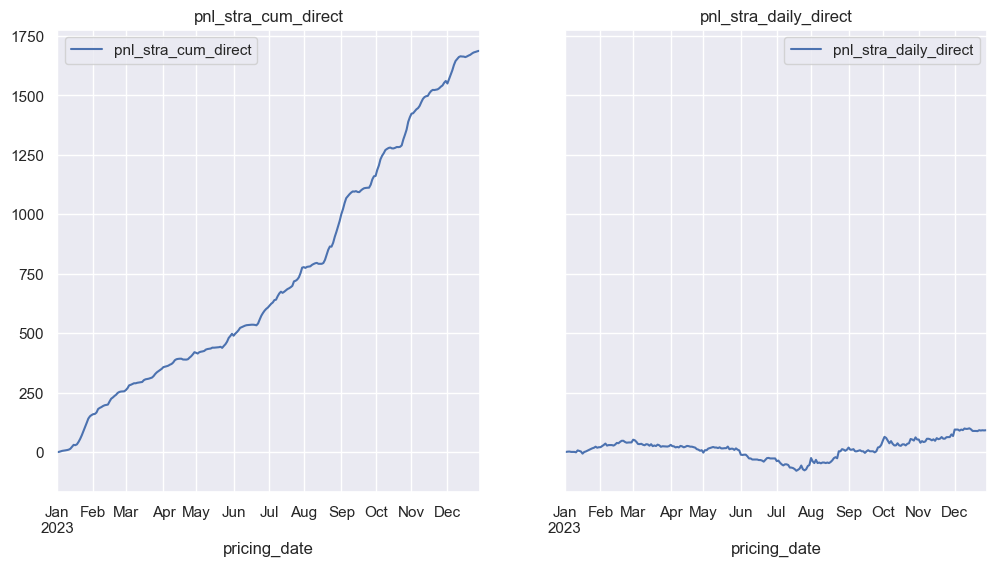

In [214]:
results = get_predictions(data.copy(), 'experiments', '2023-01-01', '2023-12-31', use_features=False, n_estimators=100, target_features=None)